## 1. 데이터 준비

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline
plt.rcParams['font.family'].insert(0, 'Malgun Gothic')
sns.set(font="Malgun Gothic", rc = {"axes.unicode_minus":False}, style='whitegrid')
plt.rcParams["figure.figsize"] = (15, 6)
sns.set_palette('pastel')

In [3]:
df_init = pd.read_csv('../Data/df_유통사.csv')
print('Dataframe dimensions:', df_init.shape)
#______
df_init['연령대'] = df_init['연령대'].apply(lambda x: int(x[:-1]))
#____________________________________________________________
# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(df_init.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_init.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_init.isnull().sum()/df_init.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)
#__________________
# show first lines
display(df_init[:5])

Dataframe dimensions: (4381743, 21)


,고객번호,영수증,채널,유통사,점포코드,상품코드,이용일자,이용시간,이용금액,구매수량,...,연령대,거주지,소분류,대분류,중분류,제휴사,점포_대분류,점포_중분류,LPoint,휴일
column type,object,object,int64,object,object,object,int64,int64,float64,int64,...,int64,object,object,object,object,object,object,object,int64,int64
null values (nb),0,0,0,0,428501,0,0,0,0,0,...,0,0,0,0,0,428501,428501,428501,0,0
null values (%),0.0,0.0,0.0,0.0,9.779236,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,9.779236,9.779236,9.779236,0.0,0.0


,고객번호,영수증,채널,유통사,점포코드,상품코드,이용일자,이용시간,이용금액,구매수량,...,연령대,거주지,소분류,대분류,중분류,제휴사,점포_대분류,점포_중분류,LPoint,휴일
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1,...,50,Z17,남성티셔츠,남성의류,남성의류상의,A01,Z10,Z10042,0,1
1,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1,...,50,Z17,남성티셔츠,남성의류,남성의류상의,A01,Z10,Z10042,0,1
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1,...,50,Z17,남성티셔츠,남성의류,남성의류상의,A01,Z10,Z10042,0,1
3,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1,...,50,Z17,남성티셔츠,남성의류,남성의류상의,A01,Z10,Z10042,0,1
4,M646853852,A01269523084,1,A01,A010025,PD0290,20210716,20,20000.0,1,...,40,Z13,남성티셔츠,남성의류,남성의류상의,A01,Z13,Z13001,0,0


## 2. 변수 살펴보기

In [4]:
print(df_init.columns)

Index(['고객번호', '영수증', '채널', '유통사', '점포코드', '상품코드', '이용일자', '이용시간', '이용금액',
       '구매수량', '성별', '연령대', '거주지', '소분류', '대분류', '중분류', '제휴사', '점포_대분류',
       '점포_중분류', 'LPoint', '휴일'],
      dtype='object')


In [5]:
df = df_init.drop(['영수증', '구매수량', '소분류', '중분류', '점포_중분류', '점포코드', '제휴사','점포_대분류'], axis=1)
df.columns

Index(['고객번호', '채널', '유통사', '상품코드', '이용일자', '이용시간', '이용금액', '성별', '연령대', '거주지',
       '대분류', 'LPoint', '휴일'],
      dtype='object')

In [15]:
# 유통사
df_dummies = pd.get_dummies(df, columns=['유통사','성별'])
df_dummies.columns

Index(['고객번호', '채널', '상품코드', '이용일자', '이용시간', '이용금액', '연령대', '거주지', '대분류',
       'LPoint', '휴일', '유통사_A01', '유통사_A02', '유통사_A03', '유통사_A04', '유통사_A05',
       '유통사_A06', '성별_남성', '성별_여성'],
      dtype='object')

In [16]:
df_train = df_dummies.drop(['고객번호', '상품코드', '거주지', '대분류'], axis=1)

## 3. K-Means

In [17]:
ks = range(1, 20)
inertias = []
for k in ks:
    model = KMeans(n_clusters=k, n_init=5)
    %time model.fit(df_train)
    inertias.append(model.inertia_)
    print('n_cluster:{}, inertia:{}'.format(k, model.inertia_))


Wall time: 2.83 s
n_cluster:1, inertia:2.314112399221826e+17
Wall time: 11.6 s
n_cluster:2, inertia:1.155458749925375e+17
Wall time: 15.1 s
n_cluster:3, inertia:6.5876291227230936e+16
Wall time: 23 s
n_cluster:4, inertia:3.936674516881012e+16
Wall time: 24.4 s
n_cluster:5, inertia:2.55803443613062e+16
Wall time: 33.6 s
n_cluster:6, inertia:1.9555654063624144e+16
Wall time: 36.2 s
n_cluster:7, inertia:1.5076640476340258e+16
Wall time: 47.8 s
n_cluster:8, inertia:1.104171634136312e+16
Wall time: 42.2 s
n_cluster:9, inertia:8737339708210083.0
Wall time: 55.5 s
n_cluster:10, inertia:6805821761288803.0
Wall time: 45.2 s
n_cluster:11, inertia:5623109270915747.0
Wall time: 41.7 s
n_cluster:12, inertia:4739818021950480.0
Wall time: 56.8 s
n_cluster:13, inertia:4185118852218536.0
Wall time: 1min 6s
n_cluster:14, inertia:3597963198408440.0
Wall time: 1min
n_cluster:15, inertia:3103913184701745.5
Wall time: 1min 7s
n_cluster:16, inertia:2728908294318676.0
Wall time: 1min 37s
n_cluster:17, inertia

NameError: name 'pltfigure' is not defined

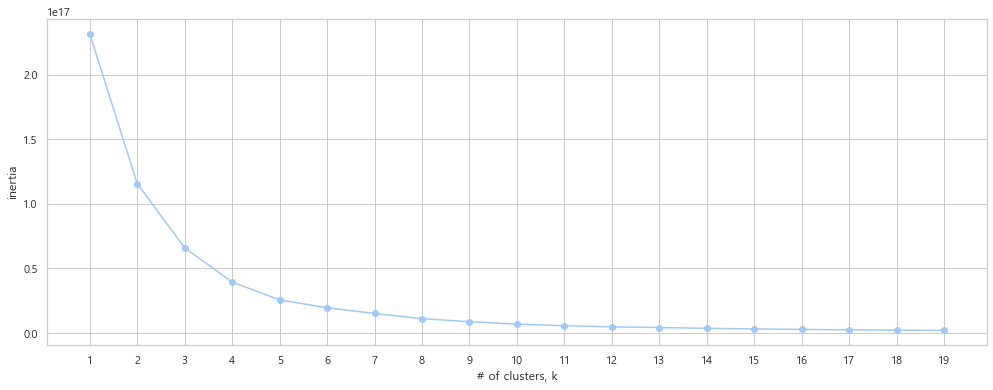

In [19]:
plt.figure(figsize=(15,6))
plt.plot(ks, inertias, '-o')
plt.xlabel('# of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [20]:
from sklearn.metrics.cluster import silhouette_Score

model = KMeans(n_clusters = 5)
k_model = model.fit(df_train)
cluster = k_model.labels_

print('Silhouette Score:', silhouette_score(df_train, cluster))

ModuleNotFoundError: No module named 'sklean'

In [21]:
from sklearn.cluster import KMeans

k = 5

# 그룹 수, random_state 설정
model = KMeans(n_clusters = k, random_state = 10)

# 정규화된 데이터에 학습
model.fit(df_train)

# 클러스터링 결과 각 데이터가 몇 번째 그룹에 속하는지 저장
df['cluster'] = model.fit_predict(df_train)

In [22]:
set(df['cluster'])

{0, 1, 2, 3, 4}

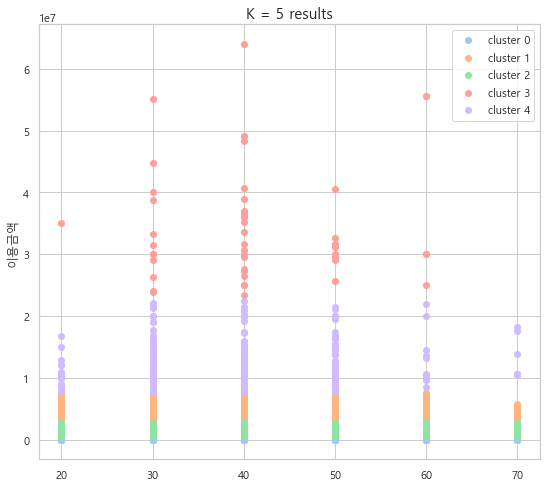

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 8))

for i in range(k):
    plt.scatter(df.loc[df['cluster'] == i, '연령대'], df.loc[df['cluster'] == i, '이용금액'], 
                label = 'cluster ' + str(i))

plt.legend()
plt.title('K = %d results'%k , size = 15)
plt.xlabel('', size = 12)
plt.ylabel('이용금액', size = 12)
plt.show()

In [25]:
df.groupby(['cluster'], as_index=False).size()

,cluster,size
0,0,4358859
1,1,3576
2,2,18772
3,3,50
4,4,486
